## Предсказание стоимости машины методом линейной регрессии


Попробуем предсказать стоимость машин и понять, от каких факторов зависит ценообразование на автомобили.  
Помимо этого узнаем, какие переменные важны для прогнозирования и насколько хорошо полученная модель описывает данные. 

Задание:  
Загрузите данные, проверьте правильность, наличие пропущенных значений, типы данных.  
Создайте новый признак – марку автомобиля (company). 
Машины каких производителей встречаются в датасете? Исправьте названия и проверьте изменения.  
Оставьте только часть предикторов, после чего посчитайте корреляцию между price и другими переменными.  
Преобразуйте категориальные переменные с помощью pd.get_dummies().   
Постройте модель с одним предиктором цены – horsepower. Какой процент изменчивости объясняет полученная модель? 
Далее – две модели (со всеми предикторами и со всеми, кроме марок машин).  
Обратите внимание на изменения в R2, коэффициентах и их значимости. Какую модель лучше оставить?   
Заполните пропуски в результатах.

car_ID - id  
symboling - символ  
CarName - марка  
fueltype - топливо   
aspiration - тип двигателя  
doornumber - число дверей  
carbody - тип кузова  
drivewheel - привод  
enginelocation - расположение двигателя  
wheelbase - колесная база  
carlength - длина автомобиля  
carwidth - ширина машины  
carheight - высота автомобиля  
curbweight - снаряженная масса  
enginetype - тип двигателя  
cylindernumber - число цилиндров  
enginesize - объём двигателя  
fuelsystem - топливная система  
boreratio - проходимость  
stroke - клиренс  
compressionratio - коэффициент сжатия  
horsepower - лошадиных сил  
peakrpm - макс оборотов  
citympg - городской расход топлива  
highwaympg - расход топлива на трассе  
price - цена  

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm

import seaborn as sns
sns.set(style='whitegrid', rc={'figure.figsize': (16,5)})

In [2]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/387691/cars.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

In [4]:
print(df.isna().sum().sum(), 'пропущенных значений встретилось в датасете') 

0 пропущенных значений встретилось в датасете


Сгенерируем первый признак.  
Использовать полное название машины – не самый хороший вариант, поэтому создадим новый признак – марку автомобиля (company).  
Для этого используем столбец CarName  

In [5]:
df['company'] = df['CarName'].apply(lambda x: x.split()[0])

удаляем CarName с полным названием машины из датасета, а также car_ID, они не пригодятся для дальнейшего анализа.

In [6]:
df = df.drop(columns=['CarName', 'car_ID'], axis=1)

In [7]:
print(f'всего {df.company.nunique()} уникальных марок машин встречается в датасете') 

всего 28 уникальных марок машин встречается в датасете


Посмотрим на уникальные значения company. Часть из них оказалась с ошибками! Устраняем.

In [24]:
def fix_company(old_name):
    update = {'maxda': 'mazda', 'Nissan': 'nissan', 'porcshce': 'porsche', 'toyouta': 'toyota', \
              'vokswagen': 'volkswagen', 'vw': 'volkswagen'}
    if old_name in update.keys():
        return update[old_name]
    else:
        return old_name

df['company'] = df['company'].apply(fix_company)

In [25]:
print(df.company.nunique(), 'уникальных производителей осталось в итоге')

22 уникальных производителей осталось в итоге


Чтобы не перегружать модель большим количеством предикторов, оставим только часть из них:  
'company', 'fueltype', 'aspiration','carbody', 'drivewheel', 'wheelbase', 'carlength','carwidth', 'curbweight', 'enginetype', 'cylindernumber', 'enginesize', 'boreratio','horsepower', 'price'. 

In [10]:
need_columns = ['company', 'fueltype', 'aspiration','carbody', 'drivewheel', 'wheelbase', 'carlength','carwidth', \
                'curbweight', 'enginetype', 'cylindernumber', 'enginesize', 'boreratio','horsepower', 'price']
df = df[need_columns]

Считаем корреляцию между price и другими переменными.

In [11]:
df.corr()['price'].sort_values(ascending=False)

price         1.000000
enginesize    0.874145
curbweight    0.835305
horsepower    0.808139
carwidth      0.759325
carlength     0.682920
wheelbase     0.577816
boreratio     0.553173
Name: price, dtype: float64

Так как линейная регрессия в python не справляется с категориальными переменными, поэтому применим функцию pd.get_dummies().  
Она создаёт т.н. фиктивные переменные на основе изначальных категорий, представленные в виде 0 и 1. (One-Hot Encoding) 

Для начала применим её только на категориальных переменных, и сравним результат с изначальными данными.   

In [13]:
df.select_dtypes('object').columns.to_list()

['company',
 'fueltype',
 'aspiration',
 'carbody',
 'drivewheel',
 'enginetype',
 'cylindernumber']

In [14]:
df_dummy = pd.get_dummies(data=df[df.select_dtypes('object').columns.to_list()], drop_first = True)
df_dummy.head()

,company_audi,company_bmw,company_buick,company_chevrolet,company_dodge,company_honda,company_isuzu,company_jaguar,company_mazda,company_mercury,...,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0


Теперь применим её ко всему датафрейму (с тем же набором колонок, что и на предыдущем шаге).  

In [15]:
df_dum = pd.get_dummies(data=df[df.columns.to_list()], drop_first = True)
df_dum.head()

,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,price,company_audi,company_bmw,...,enginetype_ohc,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two
0,88.6,168.8,64.1,2548,130,3.47,111,13495.0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,88.6,168.8,64.1,2548,130,3.47,111,16500.0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,94.5,171.2,65.5,2823,152,2.68,154,16500.0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,99.8,176.6,66.2,2337,109,3.19,102,13950.0,1,0,...,1,0,0,0,0,1,0,0,0,0
4,99.4,176.6,66.4,2824,136,3.19,115,17450.0,1,0,...,1,0,0,0,1,0,0,0,0,0


Сначала построим небольшую модель всего с одним предиктором цены (price) – horsepower.  

In [17]:
prc_hrspwr = df_dum.copy()
results = smf.ols('price ~ horsepower', prc_hrspwr).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     382.2
Date:                Thu, 04 May 2023   Prob (F-statistic):           1.48e-48
Time:                        18:29:21   Log-Likelihood:                -2024.0
No. Observations:                 205   AIC:                             4052.
Df Residuals:                     203   BIC:                             4059.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3721.7615    929.849     -4.003      0.0

R-squared: 0.653  
65 процентов изменчивости объясняет полученная модель

In [26]:
prc_hrspwr['horsepower_cent'] = prc_hrspwr['horsepower'] - prc_hrspwr['horsepower'].mean()
prc_hrspwr.head()

,wheelbase,carlength,carwidth,curbweight,enginesize,boreratio,horsepower,price,company_audi,company_bmw,...,enginetype_ohcf,enginetype_ohcv,enginetype_rotor,cylindernumber_five,cylindernumber_four,cylindernumber_six,cylindernumber_three,cylindernumber_twelve,cylindernumber_two,horsepower_cent
0,88.6,168.8,64.1,2548,130,3.47,111,13495.0,0,0,...,0,0,0,0,1,0,0,0,0,6.882927
1,88.6,168.8,64.1,2548,130,3.47,111,16500.0,0,0,...,0,0,0,0,1,0,0,0,0,6.882927
2,94.5,171.2,65.5,2823,152,2.68,154,16500.0,0,0,...,0,1,0,0,0,1,0,0,0,49.882927
3,99.8,176.6,66.2,2337,109,3.19,102,13950.0,1,0,...,0,0,0,0,1,0,0,0,0,-2.117073
4,99.4,176.6,66.4,2824,136,3.19,115,17450.0,1,0,...,0,0,0,1,0,0,0,0,0,10.882927


In [27]:
results = smf.ols('price ~ horsepower_cent', prc_hrspwr).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.651
Method:                 Least Squares   F-statistic:                     382.2
Date:                Thu, 04 May 2023   Prob (F-statistic):           1.48e-48
Time:                        18:46:37   Log-Likelihood:                -2024.0
No. Observations:                 205   AIC:                             4052.
Df Residuals:                     203   BIC:                             4059.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1.328e+04    329.446     

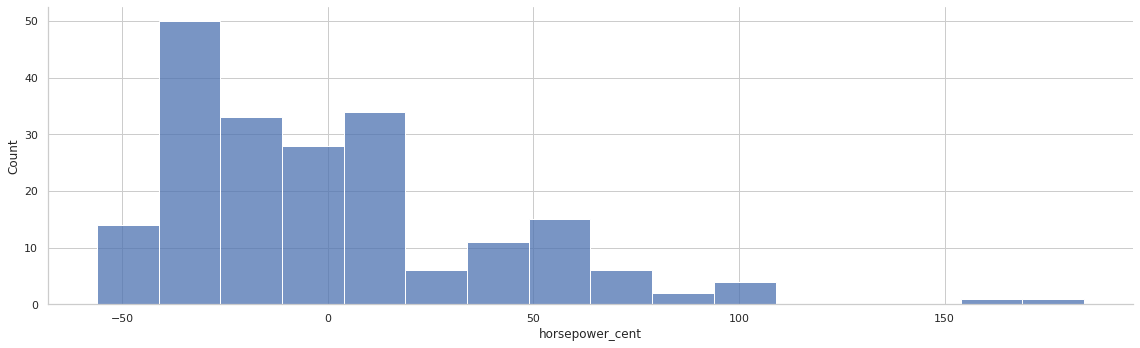

In [19]:
sns.displot(data=prc_hrspwr['horsepower_cent'], aspect=16/5)
sns.despine()

Теперь построим ещё две модели:  
- модель со всеми предикторами  
- модель со всеми предикторами, кроме марок машин  

Попробуем выбрать из этих моделей самую удачную!  
В каком-то смысле это искусство - при выборе моделей приходится ориентироваться не только на количественные показатели, но также на контекст её использования, опыт и здравый смысл.  

Посмотрите на показатели всех трёх моделей. Выберите верные утверждения:  
- Если судить чисто по диагностическим показателям (вроде R2), то модель со всеми предикторами лучшая  
- Марки машин - ключевая переменная, объясняющая большую часть дисперсии в данных, она обязательно должна быть в модели  
- Модель с одним предиктором – horsepower – очевидно лучшая!  
- Большинство коэффициентов, связанных с марками машин, статистически незначимы  

модель со всеми предикторами:

In [21]:
x = df_dum.drop(['price'], axis=1)
y = df_dum.price

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.948
Method:                 Least Squares   F-statistic:                     81.09
Date:                Thu, 04 May 2023   Prob (F-statistic):           4.86e-89
Time:                        18:29:22   Log-Likelihood:                -1804.2
No. Observations:                 205   AIC:                             3702.
Df Residuals:                     158   BIC:                             3858.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                 -3.472e+

модель со всеми предикторами, кроме марок машин:

In [22]:
df_wc = df.drop('company', axis=1)
df_wc = pd.get_dummies(data=df_wc, drop_first=True)

x = df_wc.drop(['price'], axis=1)
y = df_wc.price

x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.914
Model:                            OLS   Adj. R-squared:                  0.901
Method:                 Least Squares   F-statistic:                     72.32
Date:                Thu, 04 May 2023   Prob (F-statistic):           9.86e-81
Time:                        18:29:22   Log-Likelihood:                -1881.6
No. Observations:                 205   AIC:                             3817.
Df Residuals:                     178   BIC:                             3907.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -1.7e+

- Если судить чисто по диагностическим показателям (вроде R2), то модель со всеми предикторами лучшая  
- Большинство коэффициентов, связанных с марками машин, статистически незначимы

Можно обратить внимание, что хотя марки машин и объясняют какую-то часть общей дисперсии в данных, эта часть не самая большая - около 4%.  
На фоне того, как эта переменная усложняет модель дополнительными статнезначимыми коэффициентами, мы можем принять решение выкинуть её из модели либо дополнительно переделать. Однозначно правильного решения тут нет.

Но допустим, что мы действительно решили избавиться от этого предиктора и взять вторую модель с предыдущего шага! 